In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Read data

In [2]:
grl_dir = "../../../data/processed/00_pois_formated/aereal_data/"
res = 10

### Vivienda

In [3]:
viv_gdf = gpd.read_file(grl_dir + 'casas_deptos_mzn.gpkg')
viv_gdf = viv_gdf[['osmid','total_viv','geometry']]
viv_gdf = viv_gdf.rename(columns={'total_viv':'viv_count'})
print(viv_gdf.shape)
viv_gdf.head(2)

(214430, 3)


,osmid,viv_count,geometry
0,14609420,20.126666,POINT (-70.75478 -33.51598)
1,266255164,21.028271,POINT (-70.79327 -33.52609)


### Oficinas

In [4]:
oficina_gdf = gpd.read_file(grl_dir + 'oficinas.gpkg')
oficina_gdf = oficina_gdf.rename(columns={'Oficinas':'oficinas_count'})
print(oficina_gdf.shape)
oficina_gdf.head(2)

(229965, 3)


,osmid,oficinas_count,geometry
0,386139,12.820194,POINT (-70.64725 -33.44313)
1,386140,0.008953,POINT (-70.64767 -33.44304)


### Hoteles

In [5]:
hotel_gdf = gpd.read_file(grl_dir + 'usos_de_suelo.gpkg')
hotel_gdf = hotel_gdf[['osmid','HOTEL','geometry']].copy()
hotel_gdf = hotel_gdf.rename(columns={'HOTEL':'hotel_count'})
print(hotel_gdf.shape)
hotel_gdf.head(2)

(229965, 3)


,osmid,hotel_count,geometry
0,386139,14.213205,POINT (-70.64725 -33.44313)
1,386140,0.000000,POINT (-70.64767 -33.44304)


### Viviendas sociales

In [6]:
vivsoc_gdf = gpd.read_file(grl_dir + 'viv_social.gpkg')
vivsoc_gdf = vivsoc_gdf.rename(columns={'housing':'viv_social_count'})
print(vivsoc_gdf.shape)
vivsoc_gdf.head(2)

(34639, 3)


,osmid,viv_social_count,geometry
0,14528355,0.662426,POINT (-70.69014 -33.45685)
1,14805060,1.897061,POINT (-70.58526 -33.47253)


### NDVI

In [7]:
ndvi_gdf = gpd.read_file(grl_dir + f'Santiago_ndvi_HexRes{res}_v0.geojson')
ndvi_gdf = ndvi_gdf[['hex_id','res','ndvi_mean','geometry']]
ndvi_gdf = ndvi_gdf.rename(columns={'ndvi_mean':'ndvi_count'})
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(64190, 4)


,hex_id,res,ndvi_count,geometry
0,8ab2c5540647fff,10,0.135445,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4..."
1,8ab2c546b0cffff,10,0.287743,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5..."


<AxesSubplot: >

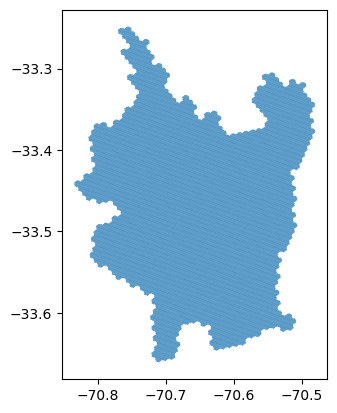

In [8]:
ndvi_gdf.plot()

### Area of interest

In [9]:
aoi = gpd.read_file("../../../data/processed/santiago/santiago_aoi.gpkg")

In [10]:
hex_gdf = aup.create_hexgrid(aoi, res)

## Merge node data

In [11]:
node_aereal = viv_gdf.merge(oficina_gdf[['osmid','oficinas_count']], 
                            on='osmid', how='inner')
node_aereal = node_aereal.merge(hotel_gdf[['osmid','hotel_count']],
                               on='osmid', how='inner')
node_aereal = node_aereal.merge(vivsoc_gdf[['osmid','viv_social_count']],
                               on='osmid', how='left')
node_aereal = node_aereal.fillna(0)
print(node_aereal.shape)
node_aereal.head(2)

(199318, 6)


,osmid,viv_count,geometry,oficinas_count,hotel_count,viv_social_count
0,14609420,20.126666,POINT (-70.75478 -33.51598),0.0,0.0,0.0
1,266255164,21.028271,POINT (-70.79327 -33.52609),0.0,0.0,0.0


## Nodes to hex

In [12]:
hex_aereal = aup.group_by_hex_mean(node_aereal, hex_gdf, res,
                                  ['viv_count','oficinas_count',
                                  'hotel_count','viv_social_count'],
                                  f'hex_id_{res}')
print(hex_aereal.shape)
hex_aereal.head(4)

(210519, 6)


,hex_id_10,geometry,viv_count,oficinas_count,hotel_count,viv_social_count
100986,8ab2c0b00007fff,"POLYGON ((-71.00842 -33.71206, -71.00905 -33.7...",0.0,0.0,0.0,0.0
46307,8ab2c0b0000ffff,"POLYGON ((-71.00760 -33.71286, -71.00824 -33.7...",0.0,0.0,0.0,0.0
169317,8ab2c0b00017fff,"POLYGON ((-71.00977 -33.71228, -71.01041 -33.7...",0.0,0.0,0.0,0.0
122339,8ab2c0b0001ffff,"POLYGON ((-71.00896 -33.71308, -71.00959 -33.7...",0.0,0.0,0.0,0.0


In [13]:
if f'hex_id_{res}' in hex_aereal.columns:
    hex_aereal = hex_aereal.rename(columns={f'hex_id_{res}':'hex_id'})

hex_aereal = hex_aereal.merge(ndvi_gdf[['ndvi_count','hex_id']],
                             on='hex_id',
                             how='right')
# hex_aereal = hex_aereal.fillna(0)
print(hex_aereal.shape)
hex_aereal.head(4)

(64190, 7)


,hex_id,geometry,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",51.747597,1.186889,7.023599,0.000000,0.135445
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.000000,0.000000,0.000000,0.287743
2,8ab2c519838ffff,"POLYGON ((-70.54047 -33.41159, -70.54110 -33.4...",15.032792,0.000000,0.000000,0.000000,0.231218
3,8ab2c54753a7fff,"POLYGON ((-70.70346 -33.52190, -70.70409 -33.5...",34.942528,0.059607,0.000000,37.203614,0.068622


<AxesSubplot: >

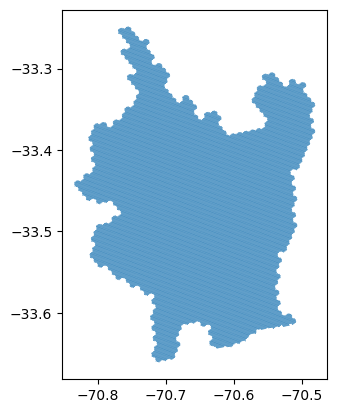

In [14]:
hex_aereal.plot()

### Save data

In [15]:
hex_aereal.to_file(grl_dir + f'hex_aereal_res{res}.gpkg')